In [91]:
import numpy as np
import matplotlib.pyplot as plt
import json
import sys

from matplotlib import rc
import pandas as pd


import subprocess
import sys
import os

import time


In [64]:
with open('config_cluster_trip.json', 'r') as f:
    config = json.load(f)
with open('output.json', 'r') as f:
    data1 = json.load(f)

# "mild" is better name than "confirmed" since people in "icu" state are also
# confirmed cases in the real world
data=data1["stats"]
data["mild"] = data["confirmed"]
del data["confirmed"]


In [65]:
config

{'graph_generation': {'category_ratios': [72, 28],
  'num_clusters': 200000,
  'num_people_per_cluster': 5},
 'simulation': {'events': [{'day': 15,
    'label': 'pocela korona',
    'prob_s_to_i': [1e-06, 1e-06]},
   {'day': 45, 'label': 'kraj uvez. korona', 'prob_s_to_i': [0, 0]}],
  'initial_params': [{'days_c_to_im': 11,
    'days_i_to_c': 5,
    'days_ic_to_im_or_d': 29,
    'days_nic': 5,
    'prob_c_neighbour_trip_candidate': 0.9,
    'prob_c_trip_candidate': 0,
    'prob_i_to_ic': 0.00471,
    'prob_ic_to_d': 0.286,
    'prob_nic_to_d': 0.36,
    'prob_s_to_i': 0,
    'prob_to_nic': 6.18e-06},
   {'days_c_to_im': 11,
    'days_i_to_c': 5,
    'days_ic_to_im_or_d': 29,
    'days_nic': 5,
    'prob_c_neighbour_trip_candidate': 0.9,
    'prob_c_trip_candidate': 0,
    'prob_i_to_ic': 0.11285,
    'prob_ic_to_d': 0.286,
    'prob_nic_to_d': 0.36,
    'prob_s_to_i': 0,
    'prob_to_nic': 6.18e-06}],
  'isolate_cluster_on_known_case': True,
  'k_trip': 10,
  'mu': 5,
  'num_icus': 200

In [68]:
data1["stopping_condition"]

a


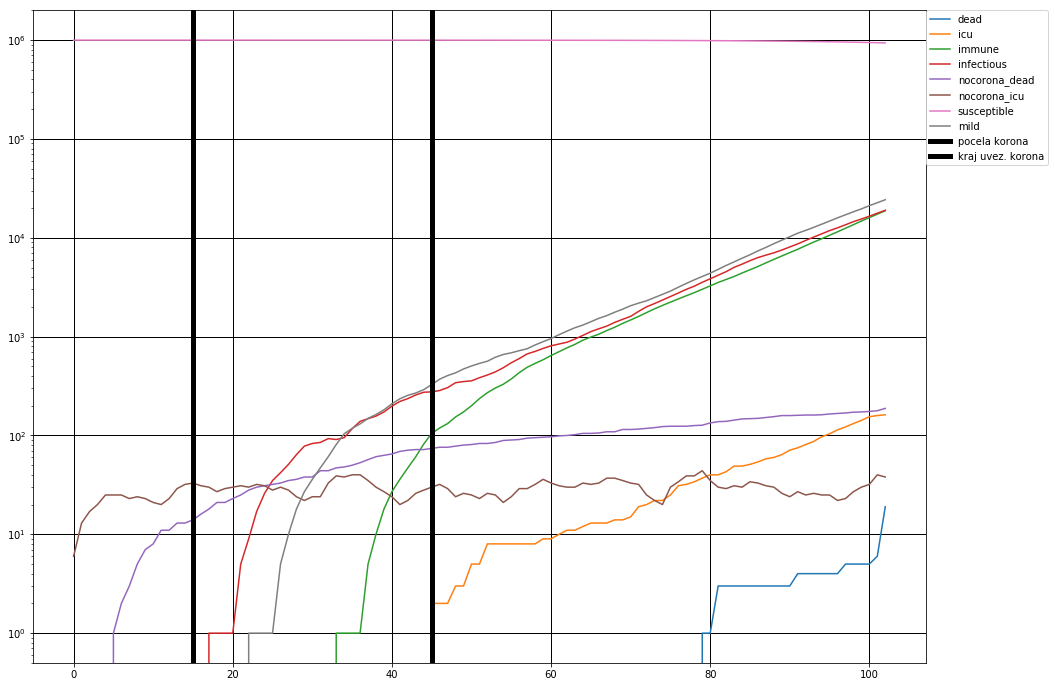

In [69]:
for state in data:
    plt.plot(np.arange(len(data[state])), data[state], label=state)
for event in config["simulation"]["events"]:
    plt.axvline(x=event["day"], label=event["label"],color="k", linewidth=5)

figure = plt.gcf() # get current figure
figure.set_size_inches(16, 12)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
plt.yscale("log")
plt.grid(color='k', linestyle='-', linewidth=1)
#plt.show()

plt.savefig('demo_NOkarantena.png')

In [7]:
data.keys()

dict_keys(['dead', 'icu', 'immune', 'infectious', 'nocorona_dead', 'nocorona_icu', 'susceptible', 'mild'])

In [8]:
type(data['dead'])

list

In [7]:
diffdead=[t - s for s, t in zip(data['dead'], data['dead'][1:])]
diffnocoronadead=[t - s for s, t in zip(data['nocorona_dead'], data['nocorona_dead'][1:])]
print(sum(diffdead))
print(sum(diffnocoronadead))

9
759


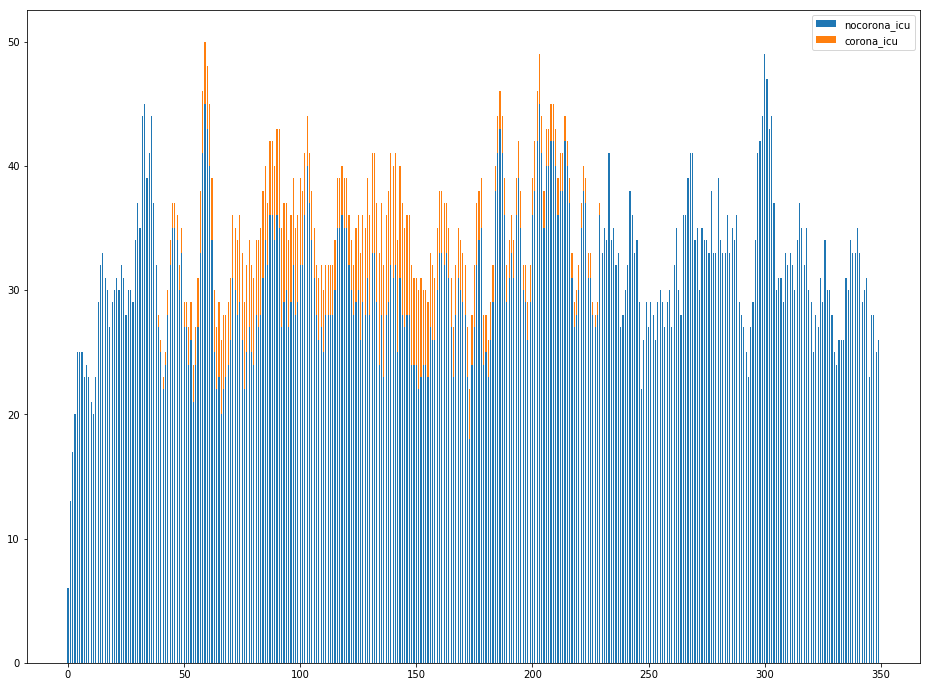

In [8]:
# y-axis in bold
#rc('font', weight='normal')

width=0.5
 
# Create brown bars
item1=plt.bar(np.arange(len(data['nocorona_icu'])), data['nocorona_icu'],width=width)
# Create green bars (middle), on top of the firs ones
item2=plt.bar(np.arange(len(data['icu'])), data['icu'], bottom=data['nocorona_icu'],width=width)
# Create green bars (top)
 
# Custom X axis
figure = plt.gcf() # get current figure
figure.set_size_inches(16, 12)
plt.legend([item1, item2], ['nocorona_icu','corona_icu'])
plt.savefig('icu_total.png')

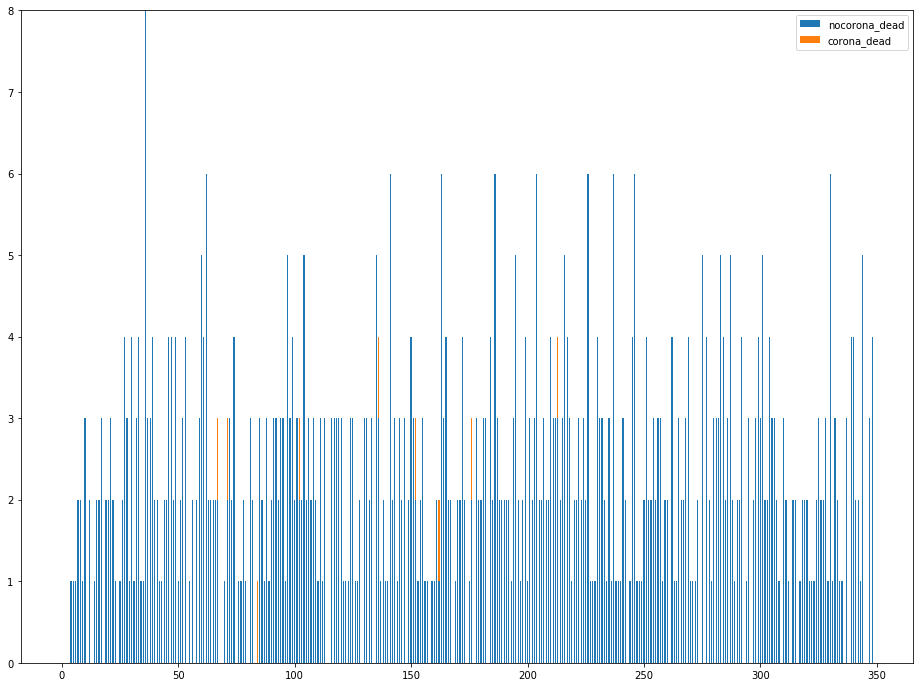

In [109]:
# y-axis in bold
#rc('font', weight='normal')
 
# Create brown bars
item1=plt.bar(np.arange(len(diffnocoronadead)), diffnocoronadead,width=width)
# Create green bars (middle), on top of the firs ones
item2=plt.bar(np.arange(len(diffdead)), diffdead, bottom=diffnocoronadead,width=width)
# Create green bars (top)
 
# Custom X axis
figure = plt.gcf() # get current figure
figure.set_size_inches(16, 12)
plt.legend([item1, item2], ['nocorona_dead','corona_dead'])
plt.savefig('dead_total.png')

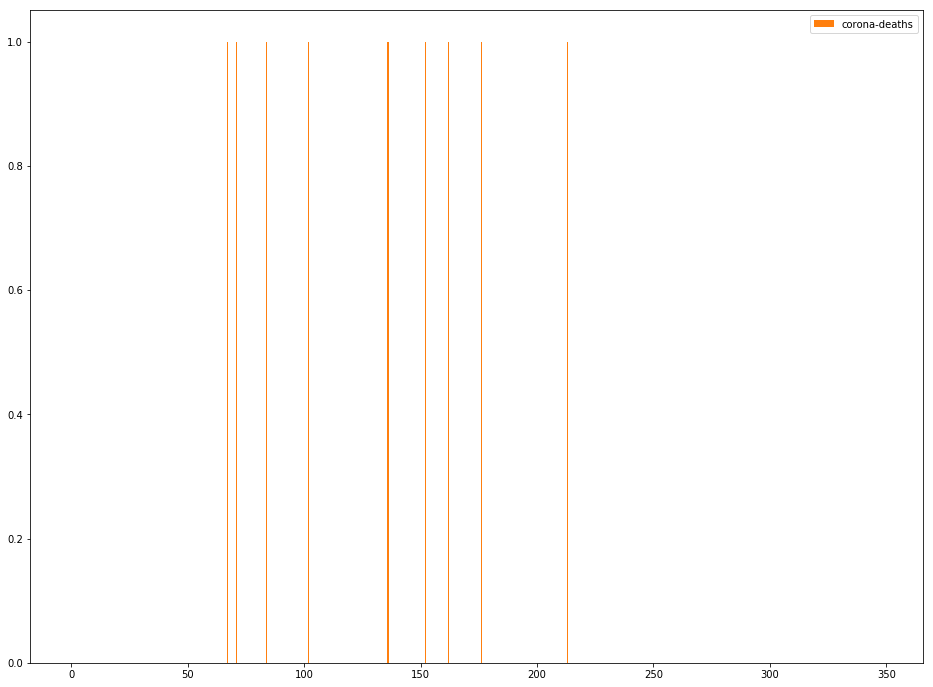

In [110]:
plt.bar(np.arange(len(diffdead)),diffdead,label='corona-deaths',color='C1',width=width)
#plt.plot(np.arange(len(diffdead)),diffdead,label='corona-deaths',color='C1')
figure = plt.gcf() # get current figure
figure.set_size_inches(16, 12)
plt.legend()
#plt.show()
plt.savefig('corona_deaths.png')

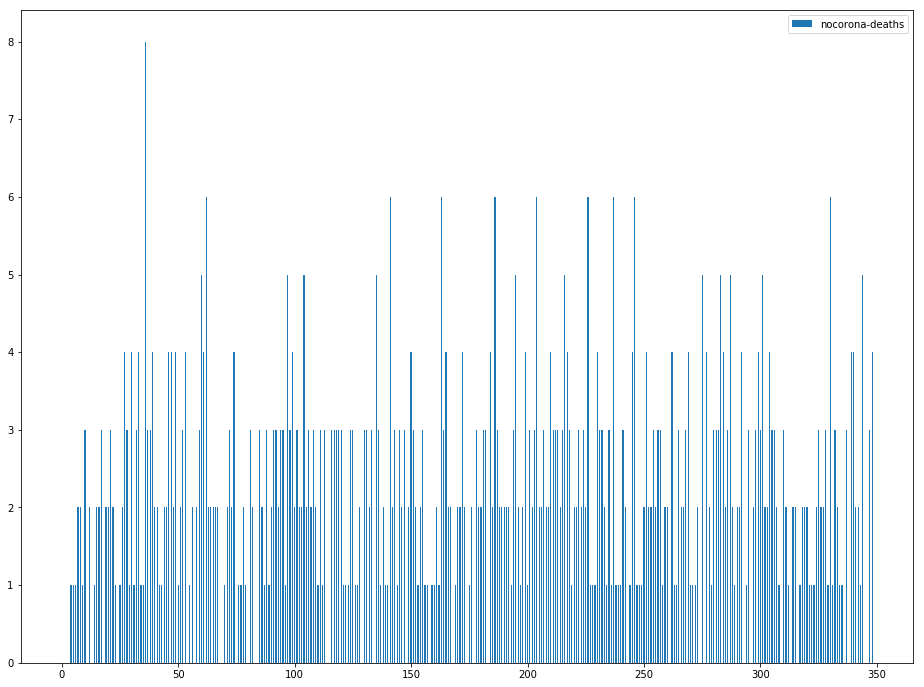

In [111]:
plt.bar(np.arange(len(diffnocoronadead)), diffnocoronadead, label='nocorona-deaths',color='C0',width=width)
#plt.plot(np.arange(len(diffnocoronadead)),diffdead,label='nocorona-deaths',color='C0')
figure = plt.gcf() # get current figure
figure.set_size_inches(16, 12)
plt.legend()
#plt.show()
plt.savefig('nocorona_deaths.png')

# GRID SEARCH

In [83]:
with open("config_cluster_trip.json") as f:
    config = json.load(f)

h=10
seeds=np.arange(0,100,1)
mu_range=np.concatenate((np.arange(0,1,0.01*h), np.arange(1,2,0.05*h),np.arange(2,5,0.1*h),np.arange(5,15.25,0.25*h) )
                        , axis=None)
ptrip=np.arange(0,1,0.01*h)
pdisobedient=np.arange(0,1,0.01*h)

results=np.zeros((len(mu_range),len(ptrip),len(pdisobedient),len(seeds)))

p1=0 # ptrip
p2=0 # pdisobedient
devnull = open(os.devnull, 'w')

step=0.01*h # ovo nam je step za p2 u while-u
mu_dict={} # ovo ce biti dictionary, keys su vrijednosti mu

for mu in mu_range:
    p1_dict={} # ovo ce biti dictionary, key su vrijednosti p1
    p2=1
    for p1 in ptrip:
        p2_list=[] # ovo ce biti lista. Tu spremamo sve vrijednosti od p2 (za svaki seed dakle) koje ce pripadati jednom p1.  
        for seed in seeds: 
            while p2>=0: 
                config["simulation"]["mu"] = mu
                config["simulation"]["prob_goes_on_trip"] = p1
                config["simulation"]["initial_params"][0]["prob_c_neighbour_trip_candidate"] = p2
                config["simulation"]["initial_params"][1]["prob_c_neighbour_trip_candidate"] = p2
                with open("tmp_config.json", "w") as f:
                    json.dump(config, f, indent=4)

                print("Running model with params: mu={}".format(mu), ", prob_goes_on_trip={}".format(p1),
                      ", prob_c_neighbour_trip_candidate={}".format(p2), "seed ={}".format(seed), file=sys.stderr)

                rez = subprocess.run(["./model_cluster_trip", "tmp_config.json", str(seed)],
                        stdout=subprocess.PIPE, stderr=devnull)
                
                # pretp da rez vraca 0 ili 1. 0 ako je failao znaci dogodilo se da je neko doso na icu i nije bilo slobodno
                # 1 ako nije, dakle sve je glatko proslo, prosli su oni uvjeti o kojima smo pricali
                
                # ako nisi jos uvik nasao rub smanji za step i nastavi.
                if rez.stdout==0:
                    p2=p2-step
                    continue
                # ako si nasao, prirodaj taj p2 listi, za iduci seed povecaj za odredjeni broj koraka.
                else: 
                    p2_list.append(p2)
                    ptemp=min(1,p2+10*step) #dignemo ga natrag za neke steppove za iduci SEED.
                    break
            p2=ptemp
        p2=max(p2_list) # za iducu iteraciju, korak udesno od p1 krecemo od max, to je sigurno dovoljno dobro.
        
        p1_dict[p1]=p2_list # listu od p2, pripajamo dictionaryju koji ima p1 kao key.
    mu_dict[mu]=p1_dict # listu od p1 pripajamo dictionaryju koji ima mu kao key.

devnull.close()
os.remove("tmp_config.json")

# na kraju svega u mu_dict imamo sve sto nam treba, easy izvucemo sve tocke, mozemo se zaebavat sa intervalima pouzdanosti itd...
# pitanje? trebalo bi provest isto sa zamijenom uloga p1 i p2! Da nadjemo intervale pouzdanosti za horizontalni dio??? 

deads = []
for result in results:
    deads.append(result["dead"][-1])

plt.plot(mu_range, deads, label="dead")
plt.show()

Running model with params: mu=0.0 , prob_goes_on_trip=0.0 , prob_c_neighbour_trip_candidate=1 seed =0


KeyboardInterrupt: 

In [9]:
config

{'graph_generation': {'category_ratios': [72, 28],
  'num_clusters': 200000,
  'num_people_per_cluster': 5},
 'simulation': {'events': [{'day': 15,
    'label': 'pocela korona',
    'prob_s_to_i': [1e-06, 1e-06]},
   {'day': 45, 'label': 'kraj uvez. korona', 'prob_s_to_i': [0, 0]}],
  'initial_params': [{'days_c_to_im': 11,
    'days_i_to_c': 5,
    'days_ic_to_im_or_d': 29,
    'days_nic': 5,
    'prob_c_neighbour_trip_candidate': 0.2,
    'prob_c_trip_candidate': 0,
    'prob_i_to_ic': 0.00471,
    'prob_ic_to_d': 0.286,
    'prob_nic_to_d': 0.36,
    'prob_s_to_i': 0,
    'prob_to_nic': 6.18e-06},
   {'days_c_to_im': 11,
    'days_i_to_c': 5,
    'days_ic_to_im_or_d': 29,
    'days_nic': 5,
    'prob_c_neighbour_trip_candidate': 0.2,
    'prob_c_trip_candidate': 0,
    'prob_i_to_ic': 0.11285,
    'prob_ic_to_d': 0.286,
    'prob_nic_to_d': 0.36,
    'prob_s_to_i': 0,
    'prob_to_nic': 6.18e-06}],
  'isolate_cluster_on_known_case': True,
  'k_trip': 10,
  'mu': 5,
  'num_icus': 200

In [92]:
with open("config_cluster_trip.json") as f:
    config = json.load(f)

scale=50
config["simulation"]["num_icus"]=config["simulation"]["num_icus"]/scale
config["graph_generation"]["num_clusters"]=config["graph_generation"]["num_clusters"]/scale
config["simulation"]["events"][0]["prob_s_to_i"]=[el * scale for el in config["simulation"]["events"][0]["prob_s_to_i"]]

h=5
seeds=np.arange(0,100,10)
mu_range=np.concatenate((np.arange(0,1,0.01*h), np.arange(1,2,0.05*h),np.arange(2,5,0.1*h),np.arange(5,15.25,0.25*h) )
                        , axis=None)
ptrip=np.arange(0,1,0.01*h)
pdisobedient=np.arange(0,1,0.01*h)

results=np.zeros((len(mu_range),len(ptrip),len(pdisobedient),len(seeds)))

p1=0 # ptrip
p2=0 # pdisobedient
devnull = open(os.devnull, 'w')

step=0.01*h # ovo nam je step za p2 u while-u
mu_dict={} # ovo ce biti dictionary, keys su vrijednosti mu

#for mu in mu_range:
mu=5
p1_dict={} # ovo ce biti dictionary, key su vrijednosti p1
p2=1
start = time.clock()
for p1 in ptrip:
    p2_list=[] # ovo ce biti lista. Tu spremamo sve vrijednosti od p2 (za svaki seed dakle) koje ce pripadati jednom p1.  
    for seed in seeds: 
        while p2>=0: 
            config["simulation"]["mu"] = mu
            config["simulation"]["prob_goes_on_trip"] = p1
            config["simulation"]["initial_params"][0]["prob_c_neighbour_trip_candidate"] = p2
            config["simulation"]["initial_params"][1]["prob_c_neighbour_trip_candidate"] = p2
            with open("tmp_config.json", "w") as f:
                json.dump(config, f, indent=4)

            print("Running model with params: mu = {}".format(mu), ", prob_goes_on_trip = {}".format(p1),
                  ", prob_c_neighbour_trip_candidate = {}".format(p2), "seed = {}".format(seed), file=sys.stderr)

            rez = subprocess.run(["./model_cluster_trip", "tmp_config.json", str(seed)],
                    stdout=subprocess.PIPE, stderr=devnull)

            # ako nisi jos uvik nasao rub smanji za step i nastavi.
            if json.loads(rez.stdout)["stopping_condition"]=="icu_overflow":
                p2=p2-step
                continue
            # ako si nasao, prirodaj taj p2 listi, za iduci seed povecaj za odredjeni broj koraka.
            else: 
                p2_list.append(p2)
                ptemp=min(1,p2+10*step) #dignemo ga natrag za neke steppove za iduci SEED.
                break
        p2=ptemp
    if (len(p2_list)==0 or np.mean(p2_list)<=0):
        break
    else:
        p2=max(p2_list) # za iducu iteraciju, korak udesno od p1 krecemo od max, to je sigurno dovoljno dobro.

    p1_dict[p1]=p2_list # listu od p2, pripajamo dictionaryju koji ima p1 kao key.
mu_dict[mu]=p1_dict # listu od p1 pripajamo dictionaryju koji ima mu kao key.

end = time.clock()  
print("Time elapsed during the calculation:", end - start)

devnull.close()
os.remove("tmp_config.json")

Running model with params: mu = 5 , prob_goes_on_trip = 0.0 , prob_c_neighbour_trip_candidate = 1 seed = 0
Running model with params: mu = 5 , prob_goes_on_trip = 0.0 , prob_c_neighbour_trip_candidate = 0.95 seed = 0
Running model with params: mu = 5 , prob_goes_on_trip = 0.0 , prob_c_neighbour_trip_candidate = 1 seed = 10
Running model with params: mu = 5 , prob_goes_on_trip = 0.0 , prob_c_neighbour_trip_candidate = 1 seed = 20
Running model with params: mu = 5 , prob_goes_on_trip = 0.0 , prob_c_neighbour_trip_candidate = 1 seed = 30
Running model with params: mu = 5 , prob_goes_on_trip = 0.0 , prob_c_neighbour_trip_candidate = 1 seed = 40
Running model with params: mu = 5 , prob_goes_on_trip = 0.0 , prob_c_neighbour_trip_candidate = 1 seed = 50
Running model with params: mu = 5 , prob_goes_on_trip = 0.0 , prob_c_neighbour_trip_candidate = 1 seed = 60
Running model with params: mu = 5 , prob_goes_on_trip = 0.0 , prob_c_neighbour_trip_candidate = 1 seed = 70
Running model with params: 

Running model with params: mu = 5 , prob_goes_on_trip = 0.2 , prob_c_neighbour_trip_candidate = 0.7999999999999994 seed = 10
Running model with params: mu = 5 , prob_goes_on_trip = 0.2 , prob_c_neighbour_trip_candidate = 0.7499999999999993 seed = 10
Running model with params: mu = 5 , prob_goes_on_trip = 0.2 , prob_c_neighbour_trip_candidate = 0.6999999999999993 seed = 10
Running model with params: mu = 5 , prob_goes_on_trip = 0.2 , prob_c_neighbour_trip_candidate = 0.6499999999999992 seed = 10
Running model with params: mu = 5 , prob_goes_on_trip = 0.2 , prob_c_neighbour_trip_candidate = 0.5999999999999992 seed = 10
Running model with params: mu = 5 , prob_goes_on_trip = 0.2 , prob_c_neighbour_trip_candidate = 0.5499999999999992 seed = 10
Running model with params: mu = 5 , prob_goes_on_trip = 0.2 , prob_c_neighbour_trip_candidate = 0.49999999999999917 seed = 10
Running model with params: mu = 5 , prob_goes_on_trip = 0.2 , prob_c_neighbour_trip_candidate = 0.9999999999999991 seed = 20

Running model with params: mu = 5 , prob_goes_on_trip = 0.25 , prob_c_neighbour_trip_candidate = 0.7999999999999998 seed = 0
Running model with params: mu = 5 , prob_goes_on_trip = 0.25 , prob_c_neighbour_trip_candidate = 0.7499999999999998 seed = 0
Running model with params: mu = 5 , prob_goes_on_trip = 0.25 , prob_c_neighbour_trip_candidate = 0.6999999999999997 seed = 0
Running model with params: mu = 5 , prob_goes_on_trip = 0.25 , prob_c_neighbour_trip_candidate = 0.6499999999999997 seed = 0
Running model with params: mu = 5 , prob_goes_on_trip = 0.25 , prob_c_neighbour_trip_candidate = 0.5999999999999996 seed = 0
Running model with params: mu = 5 , prob_goes_on_trip = 0.25 , prob_c_neighbour_trip_candidate = 0.5499999999999996 seed = 0
Running model with params: mu = 5 , prob_goes_on_trip = 0.25 , prob_c_neighbour_trip_candidate = 0.4999999999999996 seed = 0
Running model with params: mu = 5 , prob_goes_on_trip = 0.25 , prob_c_neighbour_trip_candidate = 0.4499999999999996 seed = 0


Running model with params: mu = 5 , prob_goes_on_trip = 0.25 , prob_c_neighbour_trip_candidate = 0.2999999999999992 seed = 50
Running model with params: mu = 5 , prob_goes_on_trip = 0.25 , prob_c_neighbour_trip_candidate = 0.7999999999999992 seed = 60
Running model with params: mu = 5 , prob_goes_on_trip = 0.25 , prob_c_neighbour_trip_candidate = 0.7499999999999991 seed = 60
Running model with params: mu = 5 , prob_goes_on_trip = 0.25 , prob_c_neighbour_trip_candidate = 0.6999999999999991 seed = 60
Running model with params: mu = 5 , prob_goes_on_trip = 0.25 , prob_c_neighbour_trip_candidate = 0.649999999999999 seed = 60
Running model with params: mu = 5 , prob_goes_on_trip = 0.25 , prob_c_neighbour_trip_candidate = 0.599999999999999 seed = 60
Running model with params: mu = 5 , prob_goes_on_trip = 0.25 , prob_c_neighbour_trip_candidate = 0.5499999999999989 seed = 60
Running model with params: mu = 5 , prob_goes_on_trip = 0.25 , prob_c_neighbour_trip_candidate = 0.49999999999999895 see

Running model with params: mu = 5 , prob_goes_on_trip = 0.30000000000000004 , prob_c_neighbour_trip_candidate = 0.49999999999999895 seed = 20
Running model with params: mu = 5 , prob_goes_on_trip = 0.30000000000000004 , prob_c_neighbour_trip_candidate = 0.44999999999999896 seed = 20
Running model with params: mu = 5 , prob_goes_on_trip = 0.30000000000000004 , prob_c_neighbour_trip_candidate = 0.39999999999999897 seed = 20
Running model with params: mu = 5 , prob_goes_on_trip = 0.30000000000000004 , prob_c_neighbour_trip_candidate = 0.349999999999999 seed = 20
Running model with params: mu = 5 , prob_goes_on_trip = 0.30000000000000004 , prob_c_neighbour_trip_candidate = 0.299999999999999 seed = 20
Running model with params: mu = 5 , prob_goes_on_trip = 0.30000000000000004 , prob_c_neighbour_trip_candidate = 0.249999999999999 seed = 20
Running model with params: mu = 5 , prob_goes_on_trip = 0.30000000000000004 , prob_c_neighbour_trip_candidate = 0.749999999999999 seed = 30
Running model 

Running model with params: mu = 5 , prob_goes_on_trip = 0.30000000000000004 , prob_c_neighbour_trip_candidate = 0.34999999999999887 seed = 70
Running model with params: mu = 5 , prob_goes_on_trip = 0.30000000000000004 , prob_c_neighbour_trip_candidate = 0.2999999999999989 seed = 70
Running model with params: mu = 5 , prob_goes_on_trip = 0.30000000000000004 , prob_c_neighbour_trip_candidate = 0.2499999999999989 seed = 70
Running model with params: mu = 5 , prob_goes_on_trip = 0.30000000000000004 , prob_c_neighbour_trip_candidate = 0.1999999999999989 seed = 70
Running model with params: mu = 5 , prob_goes_on_trip = 0.30000000000000004 , prob_c_neighbour_trip_candidate = 0.6999999999999988 seed = 80
Running model with params: mu = 5 , prob_goes_on_trip = 0.30000000000000004 , prob_c_neighbour_trip_candidate = 0.6499999999999988 seed = 80
Running model with params: mu = 5 , prob_goes_on_trip = 0.30000000000000004 , prob_c_neighbour_trip_candidate = 0.5999999999999988 seed = 80
Running mode

Running model with params: mu = 5 , prob_goes_on_trip = 0.35000000000000003 , prob_c_neighbour_trip_candidate = 0.3499999999999991 seed = 30
Running model with params: mu = 5 , prob_goes_on_trip = 0.35000000000000003 , prob_c_neighbour_trip_candidate = 0.2999999999999991 seed = 30
Running model with params: mu = 5 , prob_goes_on_trip = 0.35000000000000003 , prob_c_neighbour_trip_candidate = 0.2499999999999991 seed = 30
Running model with params: mu = 5 , prob_goes_on_trip = 0.35000000000000003 , prob_c_neighbour_trip_candidate = 0.19999999999999912 seed = 30
Running model with params: mu = 5 , prob_goes_on_trip = 0.35000000000000003 , prob_c_neighbour_trip_candidate = 0.14999999999999913 seed = 30
Running model with params: mu = 5 , prob_goes_on_trip = 0.35000000000000003 , prob_c_neighbour_trip_candidate = 0.09999999999999913 seed = 30
Running model with params: mu = 5 , prob_goes_on_trip = 0.35000000000000003 , prob_c_neighbour_trip_candidate = 0.04999999999999913 seed = 30
Running m

Running model with params: mu = 5 , prob_goes_on_trip = 0.35000000000000003 , prob_c_neighbour_trip_candidate = 0.19999999999999923 seed = 80
Running model with params: mu = 5 , prob_goes_on_trip = 0.35000000000000003 , prob_c_neighbour_trip_candidate = 0.14999999999999925 seed = 80
Running model with params: mu = 5 , prob_goes_on_trip = 0.35000000000000003 , prob_c_neighbour_trip_candidate = 0.09999999999999924 seed = 80
Running model with params: mu = 5 , prob_goes_on_trip = 0.35000000000000003 , prob_c_neighbour_trip_candidate = 0.5999999999999992 seed = 90
Running model with params: mu = 5 , prob_goes_on_trip = 0.35000000000000003 , prob_c_neighbour_trip_candidate = 0.5499999999999992 seed = 90
Running model with params: mu = 5 , prob_goes_on_trip = 0.35000000000000003 , prob_c_neighbour_trip_candidate = 0.49999999999999917 seed = 90
Running model with params: mu = 5 , prob_goes_on_trip = 0.35000000000000003 , prob_c_neighbour_trip_candidate = 0.4499999999999992 seed = 90
Running m

Running model with params: mu = 5 , prob_goes_on_trip = 0.4 , prob_c_neighbour_trip_candidate = 0.3499999999999993 seed = 50
Running model with params: mu = 5 , prob_goes_on_trip = 0.4 , prob_c_neighbour_trip_candidate = 0.2999999999999993 seed = 50
Running model with params: mu = 5 , prob_goes_on_trip = 0.4 , prob_c_neighbour_trip_candidate = 0.24999999999999933 seed = 50
Running model with params: mu = 5 , prob_goes_on_trip = 0.4 , prob_c_neighbour_trip_candidate = 0.19999999999999934 seed = 50
Running model with params: mu = 5 , prob_goes_on_trip = 0.4 , prob_c_neighbour_trip_candidate = 0.14999999999999936 seed = 50
Running model with params: mu = 5 , prob_goes_on_trip = 0.4 , prob_c_neighbour_trip_candidate = 0.09999999999999935 seed = 50
Running model with params: mu = 5 , prob_goes_on_trip = 0.4 , prob_c_neighbour_trip_candidate = 0.04999999999999935 seed = 50
Running model with params: mu = 5 , prob_goes_on_trip = 0.4 , prob_c_neighbour_trip_candidate = 0.5499999999999993 seed 

Running model with params: mu = 5 , prob_goes_on_trip = 0.45 , prob_c_neighbour_trip_candidate = 0.4499999999999995 seed = 20
Running model with params: mu = 5 , prob_goes_on_trip = 0.45 , prob_c_neighbour_trip_candidate = 0.3999999999999995 seed = 20
Running model with params: mu = 5 , prob_goes_on_trip = 0.45 , prob_c_neighbour_trip_candidate = 0.34999999999999953 seed = 20
Running model with params: mu = 5 , prob_goes_on_trip = 0.45 , prob_c_neighbour_trip_candidate = 0.29999999999999954 seed = 20
Running model with params: mu = 5 , prob_goes_on_trip = 0.45 , prob_c_neighbour_trip_candidate = 0.24999999999999956 seed = 20
Running model with params: mu = 5 , prob_goes_on_trip = 0.45 , prob_c_neighbour_trip_candidate = 0.19999999999999957 seed = 20
Running model with params: mu = 5 , prob_goes_on_trip = 0.45 , prob_c_neighbour_trip_candidate = 0.14999999999999958 seed = 20
Running model with params: mu = 5 , prob_goes_on_trip = 0.45 , prob_c_neighbour_trip_candidate = 0.09999999999999

Running model with params: mu = 5 , prob_goes_on_trip = 0.45 , prob_c_neighbour_trip_candidate = 0.4499999999999995 seed = 80
Running model with params: mu = 5 , prob_goes_on_trip = 0.45 , prob_c_neighbour_trip_candidate = 0.3999999999999995 seed = 80
Running model with params: mu = 5 , prob_goes_on_trip = 0.45 , prob_c_neighbour_trip_candidate = 0.34999999999999953 seed = 80
Running model with params: mu = 5 , prob_goes_on_trip = 0.45 , prob_c_neighbour_trip_candidate = 0.29999999999999954 seed = 80
Running model with params: mu = 5 , prob_goes_on_trip = 0.45 , prob_c_neighbour_trip_candidate = 0.24999999999999956 seed = 80
Running model with params: mu = 5 , prob_goes_on_trip = 0.45 , prob_c_neighbour_trip_candidate = 0.19999999999999957 seed = 80
Running model with params: mu = 5 , prob_goes_on_trip = 0.45 , prob_c_neighbour_trip_candidate = 0.14999999999999958 seed = 80
Running model with params: mu = 5 , prob_goes_on_trip = 0.45 , prob_c_neighbour_trip_candidate = 0.09999999999999

Time elapsed during the calculation: 220.4571865374376


Running model with params: mu = 5 , prob_goes_on_trip = 0.45 , prob_c_neighbour_trip_candidate = 0.04999999999999957 seed = 90


In [93]:
p1_dict

{0.0: [0.95, 1, 1, 1, 1, 1, 1, 0.95, 1, 1],
 0.05: [1, 1, 1, 0.95, 1, 1, 1, 0.95, 1, 1],
 0.1: [1, 1, 1, 1, 0.95, 1, 1, 1, 0.95, 1],
 0.15000000000000002: [1,
  0.95,
  1,
  0.8499999999999999,
  1,
  1,
  0.95,
  0.8499999999999999,
  0.95,
  0.95],
 0.2: [0.4999999999999996,
  0.49999999999999917,
  0.9499999999999991,
  0.6499999999999997,
  0.39999999999999963,
  0.24999999999999944,
  0.4999999999999993,
  0.599999999999999,
  1,
  0.8999999999999999],
 0.25: [0.049999999999999684,
  0.34999999999999976,
  0.24999999999999956,
  0.3999999999999994,
  0.09999999999999924,
  0.2999999999999992,
  0.44999999999999896,
  0.4499999999999986,
  0.14999999999999836,
  0.4499999999999983],
 0.30000000000000004: [0.14999999999999902,
  0.14999999999999902,
  0.249999999999999,
  0.2499999999999989,
  0.1499999999999988,
  0.1999999999999988,
  0.049999999999998795,
  0.1999999999999989,
  0.0999999999999988],
 0.35000000000000003: [0.09999999999999902,
  0.14999999999999902,
  0.0499999999

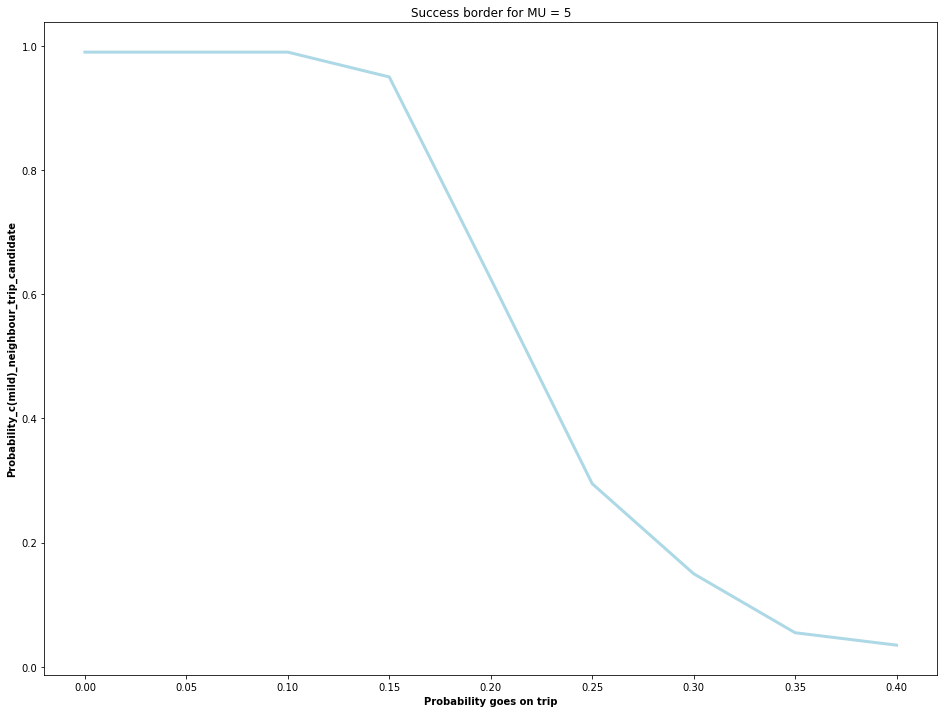

In [99]:
#rc('font', weight='bold')
rc('font', weight='normal')
plt.plot([k for k in p1_dict.keys()], [np.sum(p1_dict[k])/len(seeds) for k in p1_dict.keys()], color='lightblue', linewidth=3)
plt.title('Success border for MU = {}'.format(mu))
plt.xlabel('Probability goes on trip',weight='bold')
plt.ylabel('Probability_c(mild)_neighbour_trip_candidate',weight='bold')
figure = plt.gcf() # get current figure
figure.set_size_inches(16, 12)


In [75]:
mu_range=np.concatenate((np.arange(0,1,0.01*h), np.arange(1,2,0.05*h),np.arange(2,5,0.1*h),np.arange(5,15.25,0.25*h) )
                        , axis=None)
len(mu_range)

191